### Topic_LDA

In [ ]:
!pip install pyLDAvis
!pip install pyLDAvis.gensim
!pip install django-model-utils

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=8c193a5e8d923735d6cc150700b6c86d621165862768199f359fdb3602c5463c
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
ERROR: Could not find a version that satisfies the requirement pyLDAvis.gensim (from versions: none)
ERROR: No matching distribution found for pyLDAvis.gensim
     |████████████████████████████████| 7.9 MB 7.8 MB/s 


In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 32 kB/s 
     |████████████████████████████████| 198 kB 55.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=aa62d7f3bd6ddd0c7227449fd6e4ecf8a5e511f7b7f76d205302522d7ce9a221
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

from pyspark.sql.functions import col, count, countDistinct
from pyspark.sql import functions as F

In [ ]:
spark = SparkSession \
    .builder \
    .appName("Review-Dataframe") \
    .master("local[*]")\
    .getOrCreate()

In [ ]:
import pandas as pd
import numpy as np
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
pd.set_option('display.max_colwidth', -1)  # to view entire text in any column

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [ ]:
# df =pd.read_csv('https://raw.githubusercontent.com/sanjeevhm/BDAProject/binary_classification/Headphone_df_processed_nlp.csv')
spark_df =  spark.read.load('Headphone_df_processed_nlp.csv',
            format="csv", sep=",", header=True,
            inferSchema="true")

In [ ]:
df = spark_df.toPandas()

In [ ]:
df.shape


(24810, 8)

In [ ]:
df.head()

,_c0,product_id,product_tite,star_rating,review_headline,review_body,review_date,review_lemmatized
0,0,B003EM6AQE,Panasonic ErgoFit In-Ear Earbud Headphone,5,Great In-Ear Headphones!,I LOVE THESE HEADPHONES! I am totally satisfied with the sound and the fact that they stay in my ears! They are great...and I love the color of course. :),2015-08-31,love totally satisfied sound fact stay ear greatand love color course
1,1,B003EM8008,Panasonic ErgoFit In-Ear Earbud Headphone,5,Good quality head phones!,"Probably the best earphones ever. Better than the Apple ones, I just wished that it had a mic on it, but these will last you a long time. Just ordered my second pair (since my first one got stolen) I had these for about 5 months and it still was in good condition before someone took it. Definitely would recommend and continue to repurchase these. Also, fast shipping too.",2015-08-31,probably good earphone ever well apple one wish mic last long time order second pair since first one get steal month still good condition someone take definitely would recommend continue repurchase also fast shipping
2,2,B003EM6AOG,Panasonic ErgoFit In-Ear Earbud Headphone,5,Not bad at all!,"Great headphones, I mean they aren't going to blow your mind or anything, but they really work perfectly for the price you pay and for what they are .. these work so nicely for me when I'm trying to do some work and need outside sounds blocked out and I just want to hear the video I'm watching or the music I'm listening to.",2015-08-31,great mean go blow mind anything really work perfectly price pay work nicely try work need outside sound block want hear video watch music listening
3,3,B00E4LGVUO,Panasonic ErgoFit In-Ear Earbud Headphone,5,Five Stars,I love them for their price and quality.,2015-08-31,love price quality
4,4,B003EM8008,Panasonic ErgoFit In-Ear Earbud Headphone,5,I love these!,I love these earphones! They're very good for the price which is cheap.,2015-08-31,love earphone good price cheap


In [ ]:
headphone_df = df.drop(['Unnamed: 0'],axis = 1)

In [ ]:
headphone_df.head()

,product_id,product_tite,star_rating,review_headline,review_body,review_date,review_lemmatized
0,B003EM6AQE,Panasonic ErgoFit In-Ear Earbud Headphone,5,Great In-Ear Headphones!,I LOVE THESE HEADPHONES! I am totally satisfied with the sound and the fact that they stay in my ears! They are great...and I love the color of course. :),2015-08-31,love totally satisfied sound fact stay ear greatand love color course
1,B003EM8008,Panasonic ErgoFit In-Ear Earbud Headphone,5,Good quality head phones!,"Probably the best earphones ever. Better than the Apple ones, I just wished that it had a mic on it, but these will last you a long time. Just ordered my second pair (since my first one got stolen) I had these for about 5 months and it still was in good condition before someone took it. Definitely would recommend and continue to repurchase these. Also, fast shipping too.",2015-08-31,probably good earphone ever well apple one wish mic last long time order second pair since first one get steal month still good condition someone take definitely would recommend continue repurchase also fast shipping
2,B003EM6AOG,Panasonic ErgoFit In-Ear Earbud Headphone,5,Not bad at all!,"Great headphones, I mean they aren't going to blow your mind or anything, but they really work perfectly for the price you pay and for what they are .. these work so nicely for me when I'm trying to do some work and need outside sounds blocked out and I just want to hear the video I'm watching or the music I'm listening to.",2015-08-31,great mean go blow mind anything really work perfectly price pay work nicely try work need outside sound block want hear video watch music listening
3,B00E4LGVUO,Panasonic ErgoFit In-Ear Earbud Headphone,5,Five Stars,I love them for their price and quality.,2015-08-31,love price quality
4,B003EM8008,Panasonic ErgoFit In-Ear Earbud Headphone,5,I love these!,I love these earphones! They're very good for the price which is cheap.,2015-08-31,love earphone good price cheap


Create the Dictionary and Corpus needed for Topic Modeling

In [ ]:
type(headphone_df['review_lemmatized'])

pandas.core.series.Series

In [ ]:
headphone_df.dropna()

,product_id,product_tite,star_rating,review_headline,review_body,review_date,review_lemmatized
0,B003EM6AQE,Panasonic ErgoFit In-Ear Earbud Headphone,5,Great In-Ear Headphones!,I LOVE THESE HEADPHONES! I am totally satisfied with the sound and the fact that they stay in my ears! They are great...and I love the color of course. :),2015-08-31,love totally satisfied sound fact stay ear greatand love color course
1,B003EM8008,Panasonic ErgoFit In-Ear Earbud Headphone,5,Good quality head phones!,"Probably the best earphones ever. Better than the Apple ones, I just wished that it had a mic on it, but these will last you a long time. Just ordered my second pair (since my first one got stolen) I had these for about 5 months and it still was in good condition before someone took it. Definitely would recommend and continue to repurchase these. Also, fast shipping too.",2015-08-31,probably good earphone ever well apple one wish mic last long time order second pair since first one get steal month still good condition someone take definitely would recommend continue repurchase also fast shipping
2,B003EM6AOG,Panasonic ErgoFit In-Ear Earbud Headphone,5,Not bad at all!,"Great headphones, I mean they aren't going to blow your mind or anything, but they really work perfectly for the price you pay and for what they are .. these work so nicely for me when I'm trying to do some work and need outside sounds blocked out and I just want to hear the video I'm watching or the music I'm listening to.",2015-08-31,great mean go blow mind anything really work perfectly price pay work nicely try work need outside sound block want hear video watch music listening
3,B00E4LGVUO,Panasonic ErgoFit In-Ear Earbud Headphone,5,Five Stars,I love them for their price and quality.,2015-08-31,love price quality
4,B003EM8008,Panasonic ErgoFit In-Ear Earbud Headphone,5,I love these!,I love these earphones! They're very good for the price which is cheap.,2015-08-31,love earphone good price cheap
...,...,...,...,...,...,...,...
24805,B003ELYQGG,Panasonic ErgoFit In-Ear Earbud Headphone,5,One of the best values found for earbuds!,"These are comfortable, have good sound quality and base, and you can't beat the price! I even gave them to my teenager to test and he gave it a thumbs up!",2010-11-05,comfortable good sound quality base beat price even give teenager test give thumb
24806,B003EM8008,Panasonic ErgoFit In-Ear Earbud Headphone,4,Very Happy:),"I read the other review and was concerned, but purchased these any way. I think the sound is great. These are perfect for sitting at your desk in the office. All sounds are very clear and free from anything that may interfere with it.",2010-12-03,read review concern purchase way think sound great perfect sit desk office sound clear free anything may interfere
24807,B003EM800S,Panasonic ErgoFit In-Ear Earbud Headphone,3,Only Fair,"Well, the price is right for these, they are indeed inexpensive, and quite comfortable, but I could not hear much (if any) bass response. I just ordered some more expensive phones from Amazon[[ASIN:B002RWJD84 JBuds J3 Micro Atomic In-Ear Earphones with Travel Case (Titanium Silver)]]... hope they are better!",2010-10-12,well price right indeed inexpensive quite comfortable could hear much bass response order expensive phone amazonasinbrwjd jbuds j micro atomic inear earphones travel case titanium silver hope better
24808,B003EM8008,Panasonic ErgoFit In-Ear Earbud Headphone,2,Not to be Confused with RP-HJE160-K ErgoFit In-Ear Earbud,"So I bought these thinking they would be the same as Panasonic RP-HJE160-K ErgoFit In-Ear Earbuds but they are not. They are made of a cheaper, more flimsy material. The sound is horrible out of them too, very tinny and weak sounding. Why they name products in this manner is beyond me, but I do recommend the Panasonic RP-HJE160-K ErgoFit In-Ear Earbuds. The only thing that saves these headphones is how they fit in your ear, very comfortable.",2010-10-05,buy thinking would pan

In [ ]:
headphone_df['review_lemmatized'].isna().sum()

21

In [ ]:
reviews = headphone_df['review_lemmatized']
reviews = reviews.apply(lambda x: str(x).split())

In [ ]:
reviews

0        [love, totally, satisfied, sound, fact, stay, ear, greatand, love, color, course]                                                                                                                                                                               
1        [probably, good, earphone, ever, well, apple, one, wish, mic, last, long, time, order, second, pair, since, first, one, get, steal, month, still, good, condition, someone, take, definitely, would, recommend, continue, repurchase, also, fast, shipping]     
2        [great, mean, go, blow, mind, anything, really, work, perfectly, price, pay, work, nicely, try, work, need, outside, sound, block, want, hear, video, watch, music, listening]                                                                                  
3        [love, price, quality]                                                                                                                                                                           

In [ ]:
# Create Dictionary
dictionary = corpora.Dictionary(reviews)

In [ ]:
# number of terms
nd = dictionary.num_docs
nt = len(dictionary.keys())
print("number of documents", nd)
print("number of terms", nt)

number of documents 24810
number of terms 20242


In [ ]:
# number of terms
nd = dictionary.num_docs
nt = len(dictionary.keys())
print("number of documents", nd)
print("number of terms", nt)

number of documents 24810
number of terms 20242


In [ ]:
# Create Corpus
texts = reviews

# Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [ ]:
# Human readable format of corpus (term-frequency)
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('color', 1),
  ('course', 1),
  ('ear', 1),
  ('fact', 1),
  ('greatand', 1),
  ('love', 2),
  ('satisfied', 1),
  ('sound', 1),
  ('stay', 1),
  ('totally', 1)]]

Building the Topic Model

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True,
                                           iterations = 400)

View the topics in LDA model

In [ ]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.141*"ear" + 0.071*"fit" + 0.055*"bud" + 0.036*"come" + '
  '0.026*"comfortable" + 0.025*"noise" + 0.021*"stay" + 0.021*"size" + '
  '0.016*"ipod" + 0.016*"wear"'),
 (1,
  '0.076*"design" + 0.020*"slightly" + 0.020*"free" + 0.018*"earpiece" + '
  '0.018*"backup" + 0.018*"length" + 0.016*"open" + 0.015*"positive" + '
  '0.015*"level" + 0.014*"mostly"'),
 (2,
  '0.056*"buy" + 0.050*"use" + 0.050*"pair" + 0.045*"well" + 0.038*"one" + '
  '0.038*"would" + 0.033*"work" + 0.028*"go" + 0.020*"earphone" + '
  '0.020*"look"'),
 (3,
  '0.213*"sound" + 0.134*"good" + 0.104*"great" + 0.100*"price" + '
  '0.093*"quality" + 0.041*"really" + 0.040*"cheap" + 0.027*"comfortable" + '
  '0.015*"amazing" + 0.011*"low"'),
 (4,
  '0.049*"last" + 0.049*"month" + 0.042*"long" + 0.041*"first" + 0.031*"new" + '
  '0.031*"take" + 0.029*"wire" + 0.026*"gym" + 0.026*"every" + 0.024*"leave"'),
 (5,
  '0.100*"music" + 0.092*"listen" + 0.066*"could" + 0.038*"many" + '
  '0.031*"quite" + 0.022*"player" + 0.02

 Compute Model Perplexity and Coherence Score

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.038909373855951

Coherence Score:  0.4090729591642064


Visualize the topics-keywords

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis


/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.207011 -0.370001  1       1        23.004574
7     -0.231761 -0.001959  2       1        21.213567
0     -0.212552  0.186943  3       1        16.214029
3     -0.141754  0.226865  4       1        14.545789
6      0.091970 -0.009417  5       1        6.763519 
4      0.108158 -0.011441  6       1        5.455769 
5      0.135147 -0.007450  7       1        3.907807 
8      0.145557 -0.006610  8       1        3.474878 
1      0.155903 -0.004078  9       1        2.838644 
9      0.156344 -0.002853  10      1        2.581425 , topic_info=             Term          Freq         Total Category  logprob  loglift
7     sound        17087.000000  17087.000000  Default  30.0000  30.0000
2     ear          12608.000000  12608.000000  Default  29.0000  29.0000
20    good         10715.000000  10715.000000  Default  28.0000  28.0000
46    great        8334.000000   8334.000000   Default  27.0000  27.0000
57    price        8009.000000   8009.000000   Default  26.0000  26.0000
...     ...                ...           ...       ...      ...      ...
756   x            118.674805    119.255891    Topic10 -4.7858   3.6519 
1077  purple       117.605805    118.186929    Topic10 -4.7949   3.6519 
1087  picture      117.274025    117.855152    Topic10 -4.7977   3.6519 
870   sonys        107.513811    108.094925    Topic10 -4.8846   3.6514 
989   considering  99.149993     99.731177     Topic10 -4.9656   3.6510 

[348 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
320   4      0.998398  able      
399   4      0.998197  absolutely
265   7      0.996491  abuse     
810   9      0.999027  allow     
192   8      0.998555  almost    
...  ..           ...    ...     
41    1      0.988861  would     
41    2      0.010990  would     
208   8      0.999119  wrong     
756   10     0.997854  x         
209   1      0.999563  year      

[334 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 1, 4, 7, 5, 6, 9, 2, 10])

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    """
    Compute c_v coherence for various number of topics
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=reviews, start=1, limit=25, step=1)

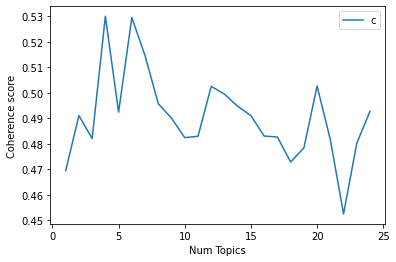

In [ ]:
# Show graph
limit=25; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.4695
Num Topics = 2  has Coherence Value of 0.4911
Num Topics = 3  has Coherence Value of 0.4821
Num Topics = 4  has Coherence Value of 0.53
Num Topics = 5  has Coherence Value of 0.4924
Num Topics = 6  has Coherence Value of 0.5295
Num Topics = 7  has Coherence Value of 0.5146
Num Topics = 8  has Coherence Value of 0.4957
Num Topics = 9  has Coherence Value of 0.4901
Num Topics = 10  has Coherence Value of 0.4824
Num Topics = 11  has Coherence Value of 0.483
Num Topics = 12  has Coherence Value of 0.5025
Num Topics = 13  has Coherence Value of 0.4995
Num Topics = 14  has Coherence Value of 0.4947
Num Topics = 15  has Coherence Value of 0.491
Num Topics = 16  has Coherence Value of 0.4831
Num Topics = 17  has Coherence Value of 0.4827
Num Topics = 18  has Coherence Value of 0.4729
Num Topics = 19  has Coherence Value of 0.4784
Num Topics = 20  has Coherence Value of 0.5027
Num Topics = 21  has Coherence Value of 0.4816
Num Topics = 22  has Coher

Coherence score for 11 topics is highest, hehce we will pick Num Topics = 11

In [ ]:
# Select the model and print the topics
optimal_model = model_list[21]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(21,
  '0.059*"pair" + 0.042*"buy" + 0.026*"one" + 0.020*"well" + 0.019*"get" + '
  '0.018*"sound" + 0.015*"price" + 0.014*"earbud" + 0.014*"good" + '
  '0.014*"another" + 0.013*"set" + 0.013*"time" + 0.013*"lose" + 0.012*"work" '
  '+ 0.012*"first" + 0.012*"order" + 0.012*"second" + 0.010*"go" + '
  '0.009*"quality" + 0.009*"try"'),
 (16,
  '0.049*"fit" + 0.043*"nice" + 0.028*"ear" + 0.023*"sound" + 0.016*"star" + '
  '0.016*"wonderful" + 0.015*"green" + 0.015*"expectation" + 0.015*"orange" + '
  '0.014*"comfortably" + 0.013*"type" + 0.013*"five" + 0.012*"nicely" + '
  '0.011*"well" + 0.010*"clean" + 0.010*"choose" + 0.009*"clear" + '
  '0.008*"inside" + 0.008*"reproduction" + 0.008*"earbud"'),
 (6,
  '0.034*"phone" + 0.027*"sound" + 0.019*"fit" + 0.018*"earbud" + 0.017*"head" '
  '+ 0.016*"ear" + 0.014*"good" + 0.012*"get" + 0.012*"quality" + 0.011*"case" '
  '+ 0.010*"jack" + 0.010*"like" + 0.009*"iphone" + 0.009*"come" + '
  '0.008*"price" + 0.008*"shape" + 0.008*"would" + 0.008*"

Topics chosen for LDA

Dominant topic in each review

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=reviews)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()



In [ ]:
# Show
df_dominant_topic.head()

,index,Dominant_Topic,Perc_Contribution,Topic_Keywords,review_lemmatized
0,0,15.0,0.6420,"color, love, perfect, match, blue, son, purple, picture, show, like","[love, totally, satisfied, sound, fact, stay, ear, greatand, love, color, course]"
1,1,21.0,0.5316,"pair, buy, one, well, get, sound, price, earbud, good, another","[probably, good, earphone, ever, well, apple, one, wish, mic, last, long, time, order, second, pair, since, first, one, get, steal, month, still, good, condition, someone, take, definitely, would, recommend, continue, repurchase, also, fast, shipping]"
2,2,2.0,0.3763,"work, still, great, well, use, fine, sound, perfectly, month, stop","[great, mean, go, blow, mind, anything, really, work, perfectly, price, pay, work, nicely, try, work, need, outside, sound, block, want, hear, video, watch, music, listening]"
3,3,10.0,0.5945,"great, sound, price, quality, comfortable, fit, product, awesome, good, buy","[love, price, quality]"
4,4,3.0,0.6284,"good, sound, price, quality, really, bass, cheap, well, would, get","[love, earphone, good, price, cheap]"


In [ ]:
df_dominant_topic.to_csv('df_dominant_topic.csv')


In [ ]:
df_dominant_topic['Dominant_Topic'].unique()

array([15., 21.,  2., 10.,  3.,  1., 19.,  9., 18., 17., 20.,  7.,  8.,
        4.,  0.,  6., 13., 12., 14.,  5., 11., 16.])

Topic distribution across reviews

In [ ]:
# Number of reviews for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']
df_dominant_topics = df_dominant_topics.dropna()
# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,15.0,"color, love, perfect, match, blue, son, purple, picture, show, like",149.0,0.0060
1.0,21.0,"pair, buy, one, well, get, sound, price, earbud, good, another",4450.0,0.1794
2.0,2.0,"work, still, great, well, use, fine, sound, perfectly, month, stop",1149.0,0.0463
3.0,10.0,"great, sound, price, quality, comfortable, fit, product, awesome, good, buy",4089.0,0.1648
4.0,3.0,"good, sound, price, quality, really, bass, cheap, well, would, get",262.0,0.0106
5.0,3.0,"good, sound, price, quality, really, bass, cheap, well, would, get",436.0,0.0176
6.0,1.0,"ear, bud, fit, come, size, sound, different, stay, small, like",758.0,0.0306
7.0,2.0,"work, still, great, well, use, fine, sound, perfectly, month, stop",312.0,0.0126
8.0,19.0,"plug, get, use, sound, earbud, cord, side, right, seem, little",237.0,0.0096
9.0,9.0,"noise, block, sound, outside, hear, well, good, earbud, bass, cancel",786.0,0.0317


In [ ]:
# quick look at topic keywords
nt = optimal_model.num_topics
for t in range(nt):
    print(t, optimal_model.show_topic(t))

0 [('sound', 0.022674335), ('offset', 0.018759582), ('ergofit', 0.013012319), ('produce', 0.011895091), ('s', 0.010889652), ('make', 0.0092709055), ('drown', 0.008748785), ('incredibly', 0.008564441), ('much', 0.008253759), ('try', 0.007897139)]
1 [('ear', 0.108372204), ('bud', 0.039093714), ('fit', 0.03782099), ('come', 0.020565014), ('size', 0.02049747), ('sound', 0.019481158), ('different', 0.016190544), ('stay', 0.015468814), ('small', 0.014099647), ('like', 0.013643322)]
2 [('work', 0.16501446), ('still', 0.038794644), ('great', 0.03606099), ('well', 0.028905815), ('use', 0.028775528), ('fine', 0.021913357), ('sound', 0.015181221), ('perfectly', 0.014674329), ('month', 0.014585246), ('stop', 0.014089504)]
3 [('good', 0.110605374), ('sound', 0.081258535), ('price', 0.051624052), ('quality', 0.050153125), ('really', 0.022065584), ('bass', 0.02187423), ('cheap', 0.017312359), ('well', 0.016523484), ('would', 0.0145127475), ('get', 0.014019184)]
4 [('ok', 0.018369455), ('review', 0.01

In [ ]:
# save topics for inspection
topic_df = pd.DataFrame(optimal_model.show_topics(nt,num_words=20), columns=['topic_num','keywords'])
topic_df.to_csv("initial_topics.csv", index = False)

In [ ]:
def out_topics_docs(ldamodel, corpus, prob0=0):
    # get a dictionary with topics as keys, and list of tuples (document_id, prob) as values
    # only keep tuples with prob > prob0
    topics_docs_dict = {}

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        # ldamodel[corpus][i] is a list of tuples (topic, prob) for document i
        for j, (topic_num, prob_topic) in enumerate(row):
            if prob_topic > prob0:
                if topic_num in topics_docs_dict:
                    topics_docs_dict[topic_num].append((i, prob_topic))  # add tuple (document_id, prob) 
                else: 
                    topics_docs_dict[topic_num] = [(i, prob_topic)]  # add the first document_id, prob pair
                
    return(topics_docs_dict)

In [ ]:
len(corpus)  # mallet produces a dense doc-topic probability matrix
topics_docs_dict = out_topics_docs(optimal_model, corpus) 
for k in sorted(topics_docs_dict.keys()):
    print("topic", k, "has", len(topics_docs_dict[k]),"documents")

topic 0 has 5487 documents
topic 1 has 11607 documents
topic 2 has 7447 documents
topic 3 has 10418 documents
topic 4 has 5710 documents
topic 5 has 5959 documents
topic 6 has 6416 documents
topic 7 has 5434 documents
topic 8 has 5725 documents
topic 9 has 6794 documents
topic 10 has 9215 documents
topic 11 has 5438 documents
topic 12 has 6572 documents
topic 13 has 6156 documents
topic 14 has 6332 documents
topic 15 has 5662 documents
topic 16 has 5500 documents
topic 17 has 8089 documents
topic 18 has 7634 documents
topic 19 has 6331 documents
topic 20 has 7454 documents
topic 21 has 7739 documents


In [ ]:
def check_topic_doc_prob(topics_docs_dict,topic_num):
    # check the distribution of probabilities for a specified topic
    prob_lst = pd.Series([x[1] for x in topics_docs_dict[topic_num] ])
    return prob_lst

In [ ]:
print("Distribution of probabilities of documents being generated from this topic:")
doc_prob = check_topic_doc_prob(topics_docs_dict, 8)
print(doc_prob.describe(),"\n")


Distribution of probabilities of documents being generated from this topic:
count    5725.000000
mean     0.074779   
std      0.104271   
min      0.010126   
25%      0.015152   
50%      0.028846   
75%      0.089340   
max      0.863636   
dtype: float64 



In [ ]:
## create topic vis

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, dictionary)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.049661 -0.008002  1       1        15.154925
3     -0.004505  0.058639  2       1        9.725986 
18     0.102403 -0.057651  3       1        9.086275 
21     0.123976  0.069359  4       1        6.933853 
20     0.123153 -0.030157  5       1        6.837934 
17     0.104362  0.054391  6       1        6.804322 
10    -0.134128  0.174865  7       1        4.653330 
12     0.070078  0.100138  8       1        4.054959 
9      0.021256 -0.043389  9       1        3.978908 
6      0.026360 -0.040386  10      1        3.921182 
2      0.055019  0.059830  11      1        3.867319 
19     0.060091 -0.162893  12      1        3.717076 
14     0.017485  0.143662  13      1        2.814101 
13    -0.001166  0.081242  14      1        2.662240 
5     -0.016852 -0.015621  15      1        2.380218 
4      0.069162 -0.097682  16      1        2.361974 
11     0.079486 -0.038857  17      1        2.231462 
0     -0.027995 -0.094803  18      1        2.076281 
8     -0.123497 -0.139994  19      1        1.875372 
16    -0.203189 -0.072032  20      1        1.726152 
15    -0.157946  0.097617  21      1        1.597321 
7     -0.233215 -0.038280  22      1        1.538810 , topic_info=          Term          Freq         Total Category  logprob  loglift
46   great      9480.000000   9480.000000   Default  30.0000  30.0000
63   work       5048.000000   5048.000000   Default  29.0000  29.0000
57   price      8649.000000   8649.000000   Default  28.0000  28.0000
2    ear        12638.000000  12638.000000  Default  27.0000  27.0000
74   fit        6122.000000   6122.000000   Default  26.0000  26.0000
..   ...                ...           ...       ...      ...      ...
593  complaint  52.692602     462.065664    Topic22 -5.0804   2.0029 
358  worth      60.894019     1082.061457   Topic22 -4.9358   1.2967 
152  low        59.989657     1515.597641   Topic22 -4.9507   0.9448 
58   really     54.939175     3343.863118   Topic22 -5.0387   0.0655 
20   good       55.263869     10761.153414  Topic22 -5.0328  -1.0974 

[1591 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
542   1      0.070995  -PRON-
542   4      0.474377  -PRON-
542   5      0.012908  -PRON-
542   6      0.203304  -PRON-
542   7      0.064541  -PRON-
...  ..           ...     ...
209   19     0.000692  year  
209   21     0.008301  year  
2267  13     0.987606  young 
1732  20     0.950524  zip   
2849  2      0.990031  zune  

[5903 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 19, 22, 21, 18, 11, 13, 10, 7, 3, 20, 15, 14, 6, 5, 12, 1, 9, 17, 16, 8])

In [ ]:
import aspect_based_sentiment_analysis as absa

In [ ]:
nlp = absa.load()


Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some layers from the model checkpoint at absa/classifier-rest-0.2 were not used when initializing BertABSClassifier: ['dropout_379']
- This IS expected if you are initializing BertABSClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertABSClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of BertABSClassifier were not initialized from the model checkpoint at absa/classifier-rest-0.2 and are newly initialized: ['dropout_37']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
text = headphone_df['review_lemmatized']
sound, color, cost,condition = nlp(text, aspects=["sound", "color", "cost",'condition'])

TypeError: ignored

In [ ]:
slack

CompletedSubTask(text='We are great fans of Slack, but we wish the subscriptions were more accessible to small startups.', aspect='slack', examples=[PredictedExample(text='We are great fans of Slack, but we wish the subscriptions were more accessible to small startups.', aspect='slack', sentiment=<Sentiment.positive: 2>, text_tokens=['we', 'are', 'great', 'fans', 'of', 'slack', ',', 'but', 'we', 'wish', 'the', 'subscriptions', 'were', 'more', 'accessible', 'to', 'small', 'startups', '.'], text_subtokens=['we', 'are', 'great', 'fans', 'of', 'slack', ',', 'but', 'we', 'wish', 'the', 'subscription', '##s', 'were', 'more', 'accessible', 'to', 'small', 'startup', '##s', '.'], aspect_tokens=['slack'], aspect_subtokens=['slack'], tokens=['[CLS]', 'we', 'are', 'great', 'fans', 'of', 'slack', ',', 'but', 'we', 'wish', 'the', 'subscriptions', 'were', 'more', 'accessible', 'to', 'small', 'startups', '.', '[SEP]', 'slack', '[SEP]'], subtokens=['[CLS]', 'we', 'are', 'great', 'fans', 'of', 'slack', 

In [ ]:
assert price.sentiment == absa.Sentiment.negative
assert slack.sentiment == absa.Sentiment.positive